In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
import seaborn as sb
%matplotlib inline

The goal is to predict the operating condition of a waterpoint for each record in the dataset. We are provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
* ~~date_recorded - The date the row was entered~~
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* ~~wpt_name - Name of the waterpoint if there is one~~
* ~~num_private~~ wtf is this?
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* ~~recorded_by - Group entering this row of data~~
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

In [2]:
trainValues = pd.read_csv('train_values.csv', parse_dates = True)
trainLabels = pd.read_csv('train_labels.csv')

In [3]:
trainValues.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
trainLabels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [31]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,62,2011-03-14,1370,1390,1519,34.938093,-9.856322,37399,0,...,6,2,1,1,8,6,0,1,1,0
1,8776,0,2013-03-06,470,1399,546,34.698766,-2.147466,37195,0,...,6,2,2,2,5,3,1,1,1,0
2,34310,13,2013-02-25,826,686,2049,37.460664,-3.821329,14572,0,...,6,2,1,1,0,1,1,2,1,0
3,67743,0,2013-01-28,1742,263,1853,38.486161,-11.155298,37285,0,...,6,2,0,0,3,0,0,2,1,2
4,19728,0,2011-07-13,21,0,120,31.130847,-1.825359,35529,0,...,6,2,3,3,5,3,1,1,1,0


In [3]:
# Predefine functions
# Function to draw trees
def Decision_Tree_Image(decision_tree, feature_names, name = "temp"):
    # Export decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree.tree_, out_file = 'images/' + name + '.dot', feature_names = feature_names)
    
    # Call graphviz to make an image file from tree
    os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the png image
    return Image(filename = "images/" + name + ".png")

# Function to draw 2D scatterplots
def Plot_Data(data, var1, var2, targetVar):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Pretty colors for dots
    color = ['red' if x == 'non functional' else 'blue' if x == 'functional' else 'green' for x in data[targetVar]]
    
    # Plot and label
    plt.scatter(data[var1], data[var2], c = color, s = 50)
    plt.xlabel(var1)
    plt.ylabel(var2)

In [4]:
# Merge along id
train = pd.merge(trainValues, trainLabels, on='id')

### Data Exploration

Count missing values (Zeros count as missing for now)

In [5]:
def countNA(dataframe):
    NA = {}
    lenData = len(dataframe)
    for col in dataframe:
        naCount = np.count_nonzero(dataframe[col])
        NA['NA_{}'.format(col)] = {'count': naCount, 'proportion': '{:.1%}'.format(float(naCount)/float(lenData))}
    return NA
        
naCount = countNA(train)        
    

In [6]:
pd.DataFrame.from_dict(naCount, orient='index')

,count,proportion
NA_amount_tsh,17761,29.9%
NA_basin,59400,100.0%
NA_construction_year,38691,65.1%
NA_date_recorded,59400,100.0%
NA_district_code,59377,100.0%
NA_extraction_type,59400,100.0%
NA_extraction_type_class,59400,100.0%
NA_extraction_type_group,59400,100.0%
NA_funder,59400,100.0%
NA_gps_height,38962,65.6%


id                       False
amount_tsh               False
date_recorded            False
funder                   False
gps_height               False
installer                False
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage               False
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting           False
recorded_by              False
scheme_management        False
scheme_name              False
permit                   False
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

In [5]:
# Make cross table for each column against status to check for patterns
def crossTab(dataframe, refCol):
    colNames = list(dataframe.drop([refCol], 1))
    ctDict = {}
    for i in colNames:
        ctDict['crossTab_{}'.format(i)] = pd.crosstab(dataframe[i], dataframe[refCol])
    return ctDict

tables = crossTab(train, 'status_group')

In [6]:
tables['crossTab_lga']

status_group,functional,functional needs repair,non functional
lga,,,
Arusha Rural,875,48,329
Arusha Urban,42,7,14
Babati,381,53,77
Bagamoyo,730,2,265
Bahi,158,0,66
Bariadi,580,409,188
Biharamulo,274,21,108
Bukoba Rural,224,97,166
Bukoba Urban,46,10,32


* crossTab_quantity: most 'dry's are non-functional
* crossTab_funder: need cleaning
* crossTab_installer: need cleaning
* crossTab_subvillage: need cleaning, might be fubar
* crossTab_region, region_code, district_code: clean. more region codes than both region and district codes, not sure why
* crossTab_scheme_name: need cleaning
* crossTab_construction_year: lots of missing data

Convert to factors

In [7]:
from sklearn import preprocessing
factorConvert = [x for x in train.columns if x not in ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time']]

for factor in factorConvert:
    train[factor] = preprocessing.LabelEncoder().fit_transform(train[factor])

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Start tree

In [62]:
excludeAttr = ['date_recorded', 'wpt_name', 'num_private', 'subvillage', 'region', 'district_code',
              'recorded_by', 'extraction_type_group', 'extraction_type_class', 'status_group', 'id']

In [63]:
Y = train['status_group']
X = train.drop(excludeAttr, axis = 1)

In [64]:
treeEntropy = DecisionTreeClassifier(max_depth = 12, criterion = 'entropy')
treeEntropy.fit(X, Y)
Decision_Tree_Image(treeEntropy, X.columns)
print "Accuracy score for tree is %.3f" %metrics.accuracy_score(treeEntropy.predict(X), Y)

Accuracy score for tree is 0.790


Initiate cross validation

In [65]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.80)

In [66]:
treeEntropy.fit(Xtrain, Ytrain)
print 'Accuracy score of tree on train = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtrain), Ytrain)
print 'Accuracy score of tree on test = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtest), Ytest) 

Accuracy score of tree on train = 0.794
Accuracy score of tree on test = 0.749


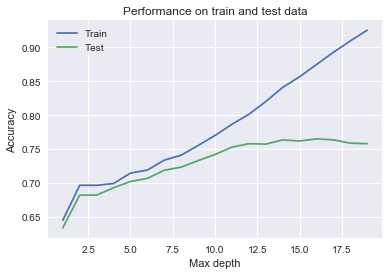

In [67]:
accuraciesTrain = []
accuraciesTest = []
depths = range(1, 20)

for md in depths:
    model = DecisionTreeClassifier(max_depth = md)
    model.fit(Xtrain, Ytrain)
    
    accuraciesTrain.append(metrics.accuracy_score(model.predict(Xtrain), Ytrain))
    accuraciesTest.append(metrics.accuracy_score(model.predict(Xtest), Ytest))

plt.plot(depths, accuraciesTrain, label = "Train")
plt.plot(depths, accuraciesTest, label = "Test")
plt.title("Performance on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

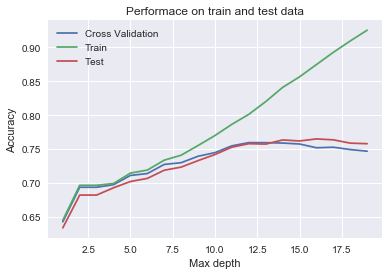

In [68]:
accuraciesCrossValidation = []
depths = range(1, 20)

for md in depths:
    model = DecisionTreeClassifier(max_depth = md)
    
    accuraciesCrossValidation.append(np.mean(cross_validation.cross_val_score(model, X, Y)))

plt.plot(depths, accuraciesCrossValidation, label = "Cross Validation")
plt.plot(depths, accuraciesTrain, label = "Train")
plt.plot(depths, accuraciesTest, label = "Test")
plt.title("Performace on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
#plt.ylim([0.8, 1.0])
#plt.xlim([1,20])
plt.legend()
plt.show()

Quite shit. Try with random forest

Tuning the model with 100 trees, 20 min samples each leaf, no restriction on number of processors used (n_jobs).

In [71]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(max_features = 'auto', n_estimators = 100, min_samples_leaf = 20,
                                     max_depth = 20, n_jobs = -1, criterion = 'entropy')
randomForest.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Things learned from fucking with the model
* no max_depth is better
* 100 trees seem optimum. More or less would result in worse performance

In [72]:
print 'Accuracy score of random forest on train = %.3f' %metrics.accuracy_score(randomForest.predict(Xtrain), Ytrain)
print 'Accuracy score of random forest on test = %.3f' %metrics.accuracy_score(randomForest.predict(Xtest), Ytest)

Accuracy score of random forest on train = 0.808
Accuracy score of random forest on test = 0.784


Create cross table of actual and predicted

In [15]:
forestPreds = randomForest.predict(Xtest)
pd.crosstab(Ytest, forestPreds, rownames=['Actual status'], colnames=['Predicted status'])

Predicted status,0,1,2
Actual status,,,
0,5827,176,516
1,466,269,124
2,1077,89,3336


Pretty shit to predict non-functional pumps it seems. False positive is not good.

In [73]:
list(zip(Xtrain, randomForest.feature_importances_))

[('amount_tsh', 0.025811378433106123),
 ('funder', 0.030934645522659735),
 ('gps_height', 0.032364155587371012),
 ('installer', 0.025875353574778114),
 ('longitude', 0.069154625285763188),
 ('latitude', 0.060561695856921831),
 ('basin', 0.018574781143512208),
 ('region_code', 0.027185952234292279),
 ('lga', 0.041212085428101099),
 ('ward', 0.024906569507566832),
 ('population', 0.020164721053435575),
 ('public_meeting', 0.017097026507897021),
 ('scheme_management', 0.01483542234617196),
 ('scheme_name', 0.022410375469041857),
 ('permit', 0.019239773519637432),
 ('construction_year', 0.044117465284060249),
 ('extraction_type', 0.039044304038538945),
 ('management', 0.015088546977570044),
 ('management_group', 0.0056819501603618486),
 ('payment', 0.020993178260463954),
 ('payment_type', 0.020753249709603475),
 ('water_quality', 0.0050093446945497413),
 ('quality_group', 0.004716030494633444),
 ('quantity', 0.11997187274332248),
 ('quantity_group', 0.10582913761625208),
 ('source', 0.0241

Initiate bagging

In [80]:
from sklearn.ensemble import BaggingClassifier
bagTree = BaggingClassifier(n_estimators = 50, n_jobs = -1)
bagTree.fit(Xtrain, Ytrain)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [81]:
print 'Accuracy score of bagged tree on train = %.3f' %metrics.accuracy_score(bagTree.predict(Xtrain), Ytrain)
print 'Accuracy score of bagged tree on test = %.3f' %metrics.accuracy_score(bagTree.predict(Xtest), Ytest)

Accuracy score of bagged tree on train = 0.999
Accuracy score of bagged tree on test = 0.792
